In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from DataSet import ImSegDataSet
import time
import segmentation_models_pytorch as smp
import numpy as np
import utils.unet_utils as ut

In [2]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_normal_(m.weight.data)
  elif isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_normal_(m.weight.data)

In [3]:
#Losses 

from utils.unet_utils import train

#Use the cross entropy loss, since we have more than two classes per pixel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def CriterionCombo(inputs,targets):

    #Get One Hot encoding of the true labels
    y_true = torch.nn.functional.one_hot(targets,24).permute(0,3,1,2).float()

    assert y_true.shape == inputs.shape
    
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)

    L1 = BCELoss(y_pred = inputs,y_true = y_true)
    L2 = TverskyLoss(y_pred = inputs,y_true = y_true)

    loss = 0.5 * L1 + 0.5 * L2

    return loss

'''
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)
        targets = torch.nn.functional.one_hot(targets,24).permute(0,3,1,2).float()       
        
        #flatten label and prediction tensors
        inputs = inputs.flatten()
        targets = targets.flatten()
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
'''

def DiceLoss(inputs,targets):
    
    #Use Tversky loss with alpha = beta = 0.5 for dice loss
    #This has the advantage of working better with possible class imbalance

    #Get One Hot encoding of the true labels
    y_true = torch.nn.functional.one_hot(targets,24).permute(0,3,1,2).float()

    assert y_true.shape == inputs.shape
    TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)

    loss = TverskyLoss(y_pred = inputs,y_true = y_true)

    return loss


In [ ]:
#crit = CriterionCombo
crit = DiceLoss

model = ut.UNet(3, 24, [64, 128, 256, 512]).to(device)
model.apply(initialize_weights)
optimizer = optim.Adam(model.parameters(), lr = 0.0003)

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=1,shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

'''
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 5, 
    buffer_update_freq = 5,
    buffer_pick_size = 3,
    n_epochs = 5,
    patch_size = 32,
    tag = "test_run_1_2023-03-20"
    )
'''

result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = 5, 
    buffer_update_freq = 1,
    buffer_pick_size = 5,
    n_epochs = 1,
    patch_size = 256,
    batch_size = 10,
    tag = "test{}".format(time.strftime("%d-%H%M%S", time.localtime(time.time()))),
    rotation = False,
    mirroring = False,
    scaling_factor = 4,
    use_original = True,
    threshold=3
    )

In [ ]:
patch_sizes = [128, 256, 512]
batch_sizes = [3,5,10]
with open(f"results/result01.txt","w") as file:
    file.write("batch_size,patch_size,accuracy,f1_score\n")
file.close()

for patch_size in patch_sizes:
    for batch_size in batch_sizes:
        
        try:
            crit = DiceLoss
            model = ut.UNet(3, 24, [64, 128, 256, 512]).to(device)
            model.apply(initialize_weights)
            optimizer = optim.Adam(model.parameters(), lr = 0.0003)

            #Data set and data loader for the training set
            DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
            DL_training = DataLoader(dataset=DS_training,batch_size=1,shuffle=True)

            #Data set and data loader for the validation set
            print("\n")
            DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
            DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

            tag = "test{}".format(time.strftime("%d-%H%M%S", time.localtime(time.time())))

            result = train(
                model = model, 
                dataloader_training = DL_training, 
                dataLoader_validation = DL_validation,
                optimizer = optimizer, 
                criterion = crit, 
                device = device, 
                buffer_size = 5, 
                buffer_update_freq = 1,
                buffer_pick_size = 5,
                n_epochs = 2,
                patch_size = patch_size,
                batch_size = batch_size,
                tag = tag,
                rotation = False,
                mirroring = False,
                scaling_factor = 4,
                use_original = True,
                threshold=3
                )
            
            acc = np.loadtxt("./results/{}/data/accuracy.txt".format(tag), skiprows=1)
            avg_acc = np.mean(acc[-5:])

            f1 = np.loadtxt("./results/{}/data/F1_score.txt".format(tag), skiprows=1)
            avg_f1 = np.mean(avg_f1[-5:])
            
            with open(f"results/result01.txt","a+") as file:
                np.savetxt(file,np.array([batch_size, patch_size, avg_acc, avg_f1]))
            file.close()    

        except RuntimeError:
            torch.cuda.empty_cache()
            continue




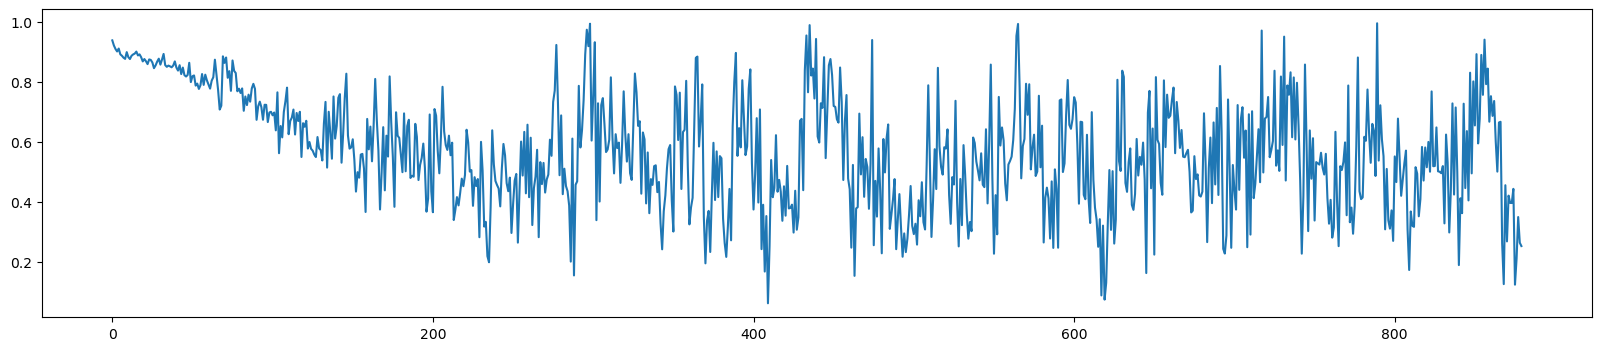

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-184443/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-185510/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batch size 5, 256x256, lr 0.002

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-191733/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batch size 7, 256x256, lr 0.002

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-193412/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batchsize 10, 128x128, lr 0.003

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test28-193412/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

Batchsize 15, 128x128

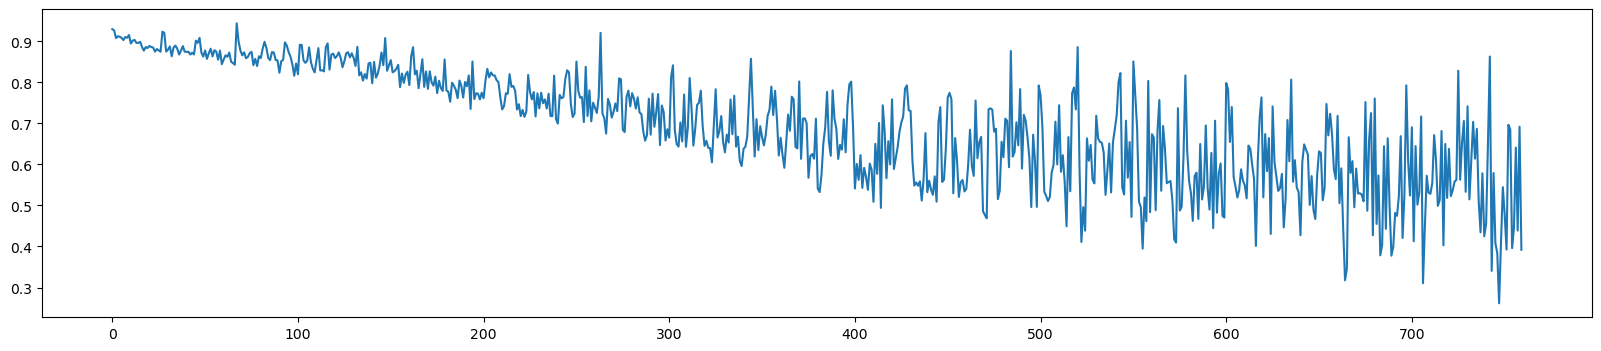

In [6]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test31-105802/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

256 x 256, 1 epoch, batch size 2, scaling factor 6, New: Selecting for images with multiple classes (threshold 3)

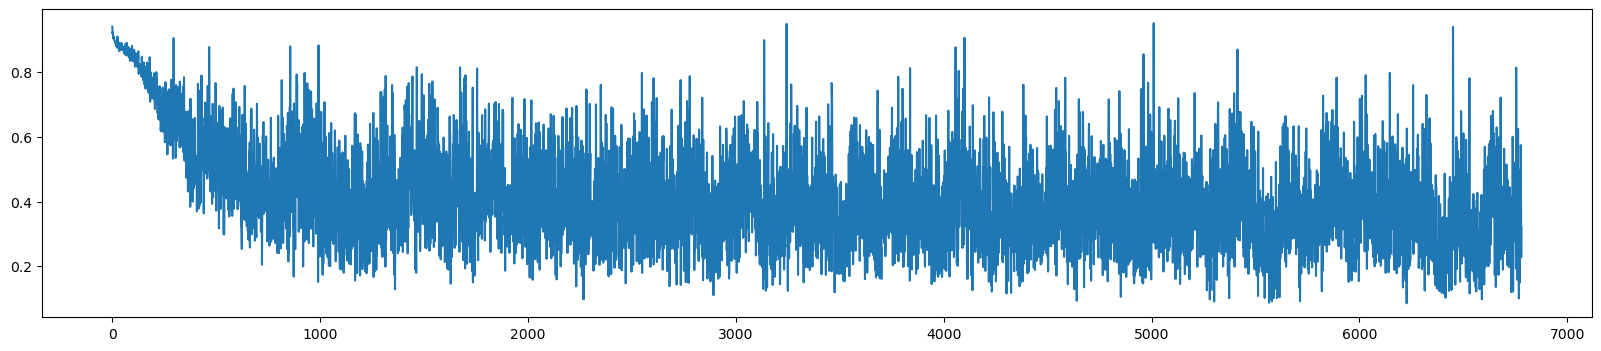

In [7]:
plt.rcParams["figure.figsize"] = (20,4)
loss = np.loadtxt("./results/test31-120614/data/training_loss.txt", skiprows=1)
plt.plot(np.arange(len(loss)), loss)

256 x 256, 2 epochs, batch size 5, scaling factor 4, using also original. New: Selecting for images with multiple classes (threshold 3), usage of downscaled dataset only

256 x 256, 1 epoch, batch size 10, scaling factor 4, using also original. New: Selecting for images with multiple classes (threshold 3), usage of downscaled dataset only